# Table of contents
1. [Introduction](#section1)

2. [Objective](#section2)

3. [Importing Libraries](#section3)

4. [Data Analysis](#section4)

    - 4.1 [Read in the Data](#section5)
    - 4.2 [Data Description](#section6)
    - 4.3 [Data Visualization](#section7)
5. [Implementation Machine Learning Algorithms](#section8)
    - 5.1 [Merge Columns](#section9)
    - 5.2 [Drop Columns](#section10)
    - 5.3 [Training and Testing Data Split](#section11)
    - 5.4 [XGBoost](#section12)

<a id='section1'></a>
<font size="4">1. Introduction</font>

Elo is one of the largest payment brands in Brazil. It has built many partnerships with merchants in order to offer promotions to cardholders. Kaggle provided a dataset consisting of historical transactions, new merchants transactions and merchant data. It also has a preset training and testing data consisting of non-described features. Since this is a kaggle competetion most of the data is well described and so some of the typical data exploratory analysis can be skipped. 

In the following sections the objectives, data exploration will be explained in more detail.


<a id='section2'></a>
<font size="4">2. Objective</font>

The objective of this competetion is to develop algorithms to identify and serve the most relevant opportunities to individuals by uncovering signal in customer loyality. This can enable Elo to create good experience for its customers. 

Before getting into developing a good algorithm, understanding the data is vital. The first and major part of this kernel will be on data exploration and getting the data ready for some machine learning algorithm.


<a id='section3'></a>
<font size="4">3. Importing Libraries</font>

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime, time, warnings
import gc
import random
import scipy


#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
plt.style.use('ggplot')
%matplotlib inline

# Machine Learning
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
#import keras

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

The first part of solving this problem is to understand the data. There are 5 datasets to consider. Lets start with the 1st and the largest dataset:

<a id='section4'></a>
<font size="4">4. Data Analysis</font>

Under this segment we'll look at the data and engineer it to our needs. However since this is a dataset from a kaggle competition most of the data is clearly described so we dont have to test it to find out what needs to be done in case of inconsistencies.                       
Lets start with taking a look at the data. Below we will read and look at a sample of the datasets. 

<a id='section5'></a>
<font size="3">4.1 Read the Data</font>

The Elo data comes in 5 different datasets, we will read all the data below. They are all in csv format which makes the reading into a dataframe easy. To help with the run time of various data manipulations and machine learning training time, a special custom function 'reduce_mem_usage' is used to reduce the size of the datasets. 

In [3]:
"""
Hist_transactions = reduce_mem_usage(pd.read_csv(r"D:\Datasets\all\historical_transactions.csv", encoding="ISO-8859-1"))
merchants = reduce_mem_usage(pd.read_csv(r"D:\Datasets\all\merchants.csv", encoding="ISO-8859-1"))
new_merchant_transactions = reduce_mem_usage(pd.read_csv(r"D:\Datasets\all\new_merchant_transactions.csv", encoding="ISO-8859-1"))
train_Raw = reduce_mem_usage(pd.read_csv(r"D:\Datasets\all\train.csv", encoding="ISO-8859-1"))
gc.collect()
"""

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 30.32 Mb (46.0% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)
Mem. usage decreased to  4.04 Mb (56.2% reduction)


11

In [39]:
#Hist_transactions = pd.read_csv(r"~/Downloads/all/historical_transactions.csv", encoding="ISO-8859-1")
#merchants = pd.read_csv(r"~/Downloads/all/merchants.csv", encoding="ISO-8859-1")
#new_merchant_transactions = pd.read_csv(r"~/Downloads/all/new_merchant_transactions.csv", encoding="ISO-8859-1")
train_Raw = pd.read_csv(r"~/Downloads/all/train.csv", encoding="ISO-8859-1")
#test_Raw = pd.read_csv(r"~/Downloads/all/test.csv", encoding="ISO-8859-1")
gc.collect()


359

<a id='section6'></a>
<font size="3">4.2 Data Description</font>

Lets start with Historical transactions and New Merchant transactions. Historical transactions dataset consists of upto 3 months worth of transactions for each card and New Merchant dataset consists of transactions at new merchants over a period of 2 months.


In [4]:
Hist_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           object
category_2              float16
state_id                int8
subsector_id            int8
dtypes: float16(1), float32(1), int16(3), int8(3), object(6)
memory usage: 1.7+ GB


In [5]:
new_merchant_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float16
purchase_date           object
category_2              float16
state_id                int8
subsector_id            int8
dtypes: float16(2), int16(3), int8(3), object(6)
memory usage: 114.2+ MB


We can see that the dataset consists of the same columns, so we can just merge the data and it should fit just fine. However, the authorized_flag column indicates which transactions were approved. There is no reason to merge (which is an expensive process) on the whole data when we can remove some part of the data, which are the rows with authorized_flag is 'N'. We can then, perform the EDA and visualization on the final data. 

In [8]:
Hist_transactions = Hist_transactions[Hist_transactions.authorized_flag == 'Y']
new_merchant_transactions = new_merchant_transactions[new_merchant_transactions.authorized_flag == 'Y']

In [9]:
dataRaw = pd.concat([Hist_transactions, new_merchant_transactions]).reset_index(drop=True)
del Hist_transactions, new_merchant_transactions
gc.collect()

14

In [6]:
dataRaw.authorized_flag.value_counts()

Y    28558483
Name: authorized_flag, dtype: int64

Since the authorized_flag has only 1 value in it, it will have no impact on the final predictions so it can be dropped. 

In [10]:
dataRaw= dataRaw.drop(['authorized_flag'], axis=1)

Now lets look at duplicates and the missing data. 

In [9]:
dataRaw.isnull().sum()

card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               213716
merchant_category_id          0
merchant_id              146272
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2196047
state_id                      0
subsector_id                  0
dtype: int64

In [8]:
dataRaw.duplicated().sum()

10

So we a lot of missing data in three columns and only 10 duplicate rows. We can drop the duplicates but the missing data needs more investigation. 

In [11]:
dataRaw = dataRaw.drop_duplicates().reset_index(drop=True)

We do not know what the category 2 and 3 consists of, this information was not revealed by the dataset creator. However, we do know that each of those columns consists of categorical object data and so if we having missing values for such data, typically the only option would be to remove the missing data. 

In [12]:
dataRaw.category_2.value_counts()

1.0    15135166
3.0     3883904
5.0     3740239
4.0     2607183
2.0      995935
Name: category_2, dtype: int64

In [13]:
dataRaw.category_3.value_counts()

A    15224828
B    11427961
C     1691969
Name: category_3, dtype: int64

In [12]:
dataRaw = dataRaw.replace({'category_3': {'A': 1,'B': 2,'C': 3}})

In [13]:
dataRaw = dataRaw.dropna(subset=['category_3', 'merchant_id', 'category_2'])
dataRaw.isnull().sum()

card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

Now that the missing data has been dealt with, let us start looking at each column. We can start with category_1. 

In [12]:
dataRaw.category_1.value_counts()

N    26031047
Name: category_1, dtype: int64

It appears that removing the missing data seems to have created an issue with category_1 as it has only 1 value. Unfortunately this means we will have to drop this column. 

In [14]:
dataRaw = dataRaw.drop(['category_1'], axis=1)

Lets now take a look at the training and testing data provided. 

In [15]:
dataRaw.head()

,card_id,city_id,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,C_ID_4e6213e9bc,88,0,1.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,C_ID_4e6213e9bc,88,0,1.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,C_ID_4e6213e9bc,88,0,1.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,C_ID_4e6213e9bc,88,0,1.0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,C_ID_4e6213e9bc,88,0,1.0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [32]:
train_Raw.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790


In [16]:
train_Raw.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

There isnt much to discuss with this dataset. There are no missing values or duplicate values, altough the features themselves arent very clear as to what they are. We will understand this data better by visualizing it in the next section. 

<a id='section7'></a>
<font size="4">5. Data Visualization</font>

So our data is processed and ready to go. Lets look at the data is see if we can make any sense of it, how the variables are related. 

Lets start with the training data. Features distribution is shown below"

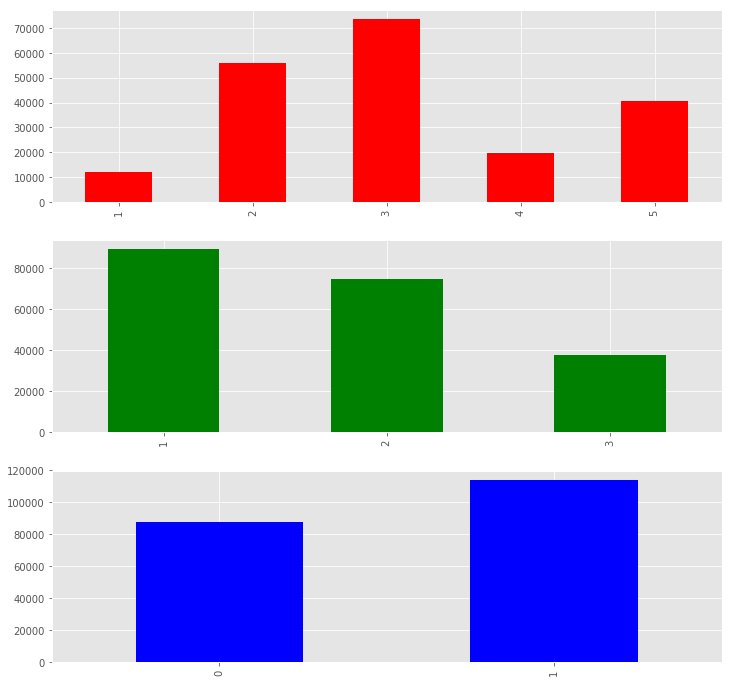

In [20]:
fig, ax = plt.subplots(3, 1, figsize = (12, 12))
train_Raw['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='red')
train_Raw['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='green')
train_Raw['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='blue');

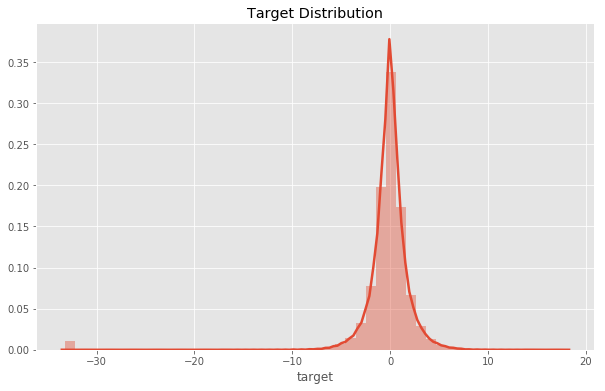

In [13]:
plt.figure(figsize=(10, 6))
plt.title('Target Distribution')
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.distplot(train_Raw['target'], hist=True, rug=False,norm_hist=True)

The train data features seems to appear normal with value '3' for feature_1 being the most prominent, '1' for feature_2 and '1' for feature_3. For target distribution, however, most of the values are around 0 as expected but there seems to be 1 value over -30. This is an outlier and will be removed. 

In [40]:
train_Raw = train_Raw[train_Raw['target'] > -15].reset_index(drop=True)

Let us now visualize the dataRaw dataset. 

Merchant_id represents unique merchants, so which merchants are most active? This can also represent the largest merchant among the list provided. 

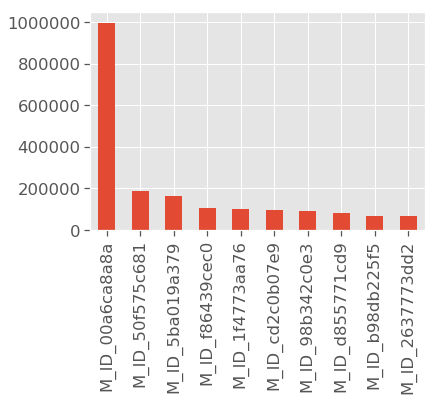

In [34]:
dataRaw['merchant_id'].value_counts().head(10).plot(kind='bar')

Unfortunately we only have unique identifiers instead of actual names but we can see that there is one merchant that seems to have a huge chunk of the transactions in the dataset. 

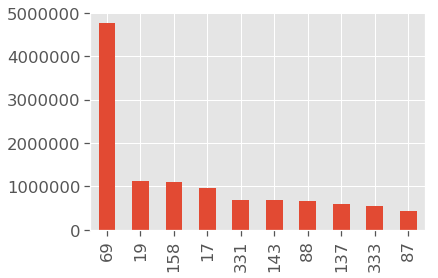

In [21]:
dataRaw['city_id'].value_counts().head(10).plot(kind='bar')

Simliar to merchants, there seems to be one city that has a major chunk of the transactions. 

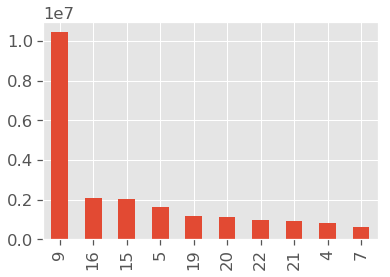

In [22]:
dataRaw['state_id'].value_counts().head(10).plot(kind='bar')

Even with the states, we can see that one state has a major part of the transactions. It is very likely that the merchant is located in the city and the state with the highest transactions. 

Let us now look at the purchase amounts. Most of the other columns are categorical data but purchase amounts is numercial with a wide range of variance in the values. 

In [19]:
dataRaw.purchase_amount.describe().apply(lambda x: format(x, 'f'))

count    26031047.000000
mean           -0.640109
std             0.550428
min            -0.747070
25%            -0.719860
50%            -0.688319
75%            -0.611188
max           430.169708
Name: purchase_amount, dtype: object

We can see from above that the majority of the values in amount are very close to 0 with most of them being negative. However, the most significant value is 430.169 which is comparatively huge. 

Visualizing the data also confirms this sentiment. 

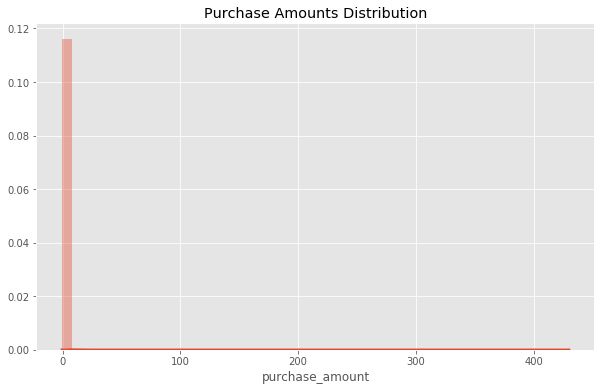

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Purchase Amounts Distribution')
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.distplot(dataRaw.purchase_amount, hist=True, rug=False,norm_hist=True)

So even though the graph shows that majority of the values are close to 0 there are many amounts that are very high. To help with this we will use custom bins. 

In [17]:
dataRaw.purchase_amount.loc[(dataRaw['purchase_amount'] >= -5.0) & (dataRaw['purchase_amount'] < 0)] = -1
dataRaw.purchase_amount.loc[(dataRaw['purchase_amount'] >= 0) & (dataRaw['purchase_amount'] < 2)] = 0
dataRaw.purchase_amount.loc[(dataRaw['purchase_amount'] >= 2) & (dataRaw['purchase_amount'] < 50)] = 1
dataRaw.purchase_amount.loc[(dataRaw['purchase_amount'] >= 50) & (dataRaw['purchase_amount'] < 500)] = 2

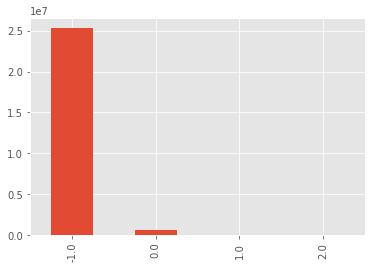

In [12]:
dataRaw['purchase_amount'].value_counts().plot(kind='bar')

In [13]:
dataRaw['purchase_amount'].value_counts()

-1.0    25295091
 0.0      639140
 1.0       96580
 2.0         236
Name: purchase_amount, dtype: int64

Bins above are sorted as: any value less than 0 is -1.0, (0, 2) is 0.0, (2, 50) is 1.0, (50, 500) is 2.0. This is just to seperate returns, low cost purchases, medium purchases and expensive purchases.  

Having used a custom bin option, it is still quite clear that a vast portion of the purchases seems to be returns and the overall value of purchases and returns seem to be very less in terms of value. Also since there doesn't seem to be any returns worth more than 5$, one can conclude that more expensive a purchase less likely people are to return it. 

Let us now look at the number of installment payments people make. 

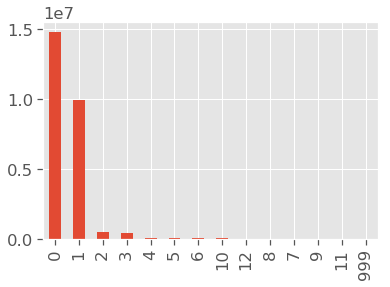

In [31]:
dataRaw['installments'].value_counts().plot(kind='bar')

In [32]:
dataRaw['installments'].value_counts()

0      14785110
1       9933051
2        543988
3        417988
4        117382
5         75995
6         74346
10        57767
12         9759
8          9493
7          4318
9          1467
11          375
999           8
Name: installments, dtype: int64

Here 0 indicates that the item was purchased in full, so no installments were made. 999 is persumably unknown number of installments. However, we can see that customers tend to pay off the item in minimal number of installments which is as expected since more installments implies more interest and hence more final cost of the product.

Let us now look at the category of the merchants. 

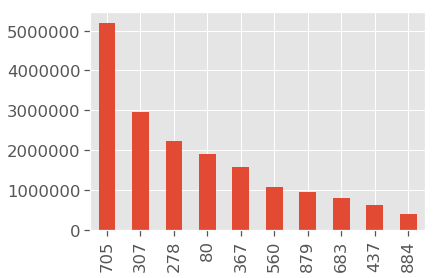

In [49]:
dataRaw['merchant_category_id'].value_counts().head(10).plot(kind='bar')

There are a lot of categories but we can see the top 10 in the graph above. We can see that the top 5 or so seem to be much higher than the rest. 

Finally let us look at the target variable from train dataset

In [55]:
train_Raw.target.describe().apply(lambda x: format(x, 'f'))

count    199699.000000
mean         -0.029999
std           0.000000
min         -14.632812
25%          -0.844238
50%          -0.007706
75%           0.777344
max          17.968750
Name: target, dtype: object

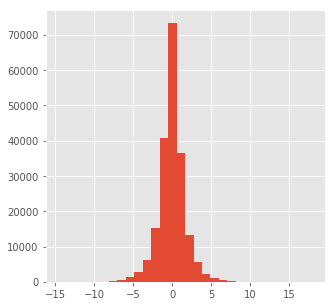

In [50]:
#train_Raw['target'].value_counts().sort_index().plot(kind='barh')
train_Raw['target'].hist(bins = 30)

We can see from above that there is a wide gap between the maximum and the minimum values and this setup does not work for a regression analysis. We can overcome this issue by converting the column into bins and make this a classification problem. 

In [41]:
custom_bucket_array = np.linspace(-16,20,10)
train_Raw.target = pd.cut(train_Raw['target'], custom_bucket_array)
train_Raw.target = train_Raw.target.astype(str)
train_Raw = train_Raw.replace({'target': {'(-16.0, -12.0]':0, '(-12.0, -8.0]':1,
                                          '(-8.0, -4.0]':2, '(-4.0, 0.0]':3,
                                          '(0.0, 4.0]': 4,
                                          '(4.0, 8.0]': 5,'(8.0, 12.0]': 6,
                                          '(12.0, 16.0]': 7,'(16.0, 20.0]': 8}})

In [42]:
train_Raw.target.value_counts()

3    98059
4    93892
2     3850
5     3570
1      164
6      128
7       17
0       17
8        2
Name: target, dtype: int64

<a id='section8'></a>
<font size="4">5. Implementation Machine Learning Algorithms</font>

Now that the data is ready to go and we can see that it looks to be as expected, let us start the machine learning part and see what insights we can gain from it. 

<a id='section9'></a>
<font size="3">5.1 Merge Columns</font>

Before we can do that though, our training and testing data has very few features which can cause some overfitting. We can merge that data with the transactions data so that there are more features for a machine learning algorithm to work with. 

In [43]:
train_Raw = pd.merge(train_Raw, dataRaw, on=['card_id'])
train_Raw = train_Raw.drop_duplicates().reset_index(drop=True)

<a id='section10'></a>
<font size="3">5.2 Drop Columns</font>

Looking at the final data, some of these columns are not useful for the machine learning algorithm such as the first_active_month or the card_id. So we are going to drop some columns as we get the data ready for machine learning. 

In [44]:
train_Raw = train_Raw.drop(['first_active_month', 'card_id', 'merchant_id', 'purchase_date'], axis=1)
train_Raw.drop_duplicates().reset_index(drop=True)
train_Raw.head()

,feature_1,feature_2,feature_3,target,city_id,installments,category_3,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
0,5,2,1,3,69,0,1.0,195,-3,-1.0,1.0,9,34
1,5,2,1,3,69,0,1.0,278,-7,-1.0,1.0,9,37
2,5,2,1,3,69,0,1.0,683,-6,-1.0,1.0,9,34
3,5,2,1,3,69,0,1.0,309,-2,-1.0,1.0,9,21
4,5,2,1,3,69,0,1.0,278,-7,-1.0,1.0,9,37


<a id='section11'></a>
<font size="3">5.3 Training and Testing Data Split</font>

We now seperate the train, validation and test data.

In [2]:
X = train_Raw.drop(['target'], axis=1)
Y = train_Raw[['target']]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

NameError: name 'train_Raw' is not defined

<a id='section12'></a>
<font size="3">5.4 XGBoost</font>

XGBoost stands for Extreme Gradient Boosting, it is a type of decision tree. It has gained popularity in recent times for its powerful performance on tabular data. Since we have such data, this algorithm is worth a shot. 

In [28]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11986013 entries, 1027849 to 12960314
Data columns (total 12 columns):
feature_1               int64
feature_2               int64
feature_3               int64
city_id                 int64
installments            int64
category_3              float64
merchant_category_id    int64
month_lag               int64
purchase_amount         float64
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(3), int64(9)
memory usage: 1.2 GB


In [29]:
#-------------- XGboost (untuned) ----------------#
import xgboost as xgb
xg_reg = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 50, alpha = 10, eval_metric="auc", n_estimators=100)
#objective ='multi:softmax'
#objective ='binary:logistic'
xg_reg.fit(x_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, eval_metric='auc', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

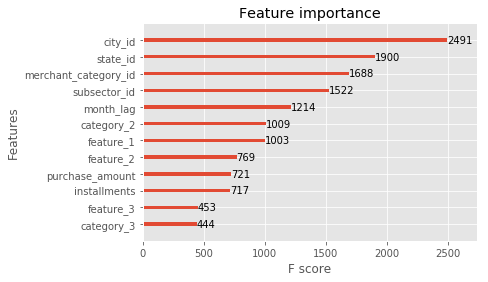

In [30]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [3]:
from sklearn.metrics import accuracy_score
from math import sqrt


pred_train = xg_reg.predict(x_train)
rms_train = accuracy_score(y_train, pred_train)

pred_test = xg_reg.predict(x_test)
rms_test = accuracy_score(y_test, pred_test)

#del Xtrain, Ytrain
#gc.collect()
print('Train Accuracy: {0} Test Accuracy: {1}'.format(rms_train*100, rms_test*100))

NameError: name 'xg_reg' is not defined

The purpose of this notebook was the EDA of Elo dataset so we are not going to dwell too much on the machine learning part but as we can see XGBoost seem to perform fairly well on this dataset. 


In [47]:
gc.collect()

123

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df